# Decision Tree Regression Analysis for Social Media Addiction Prediction

### Ahmad Tsaqif Imtinan - 5025221131
This notebook implements Decision Tree Regression to predict social media addiction levels using pre-processed student data. Exploring various scenarios including Feature Selection, Normalization, Parameter Tuning, and model optimization.

## Objectives:
1. **Testing Feature Selection**: Comparing models with and without Feature Selection
2. **Normalization Testing**: Comparing models with and without data normalization
3. **Parameter Tuning**: Optimizing the Decision Tree hyperparameters
4. **Performance Analysis**: Evaluating the performance of the model across different configurations

In [128]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [129]:
# Load the preprocessed dataset
data = pd.read_csv('../dataset/Students_Social_Media_Addiction_Feature_Engineered.csv')

# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

print("\nDataset Info:")
print(data.info())

print("\nTarget Variable Statistics:")
print(data['Addicted_Score'].describe())

Dataset Shape: (705, 25)

First 5 rows:
   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score

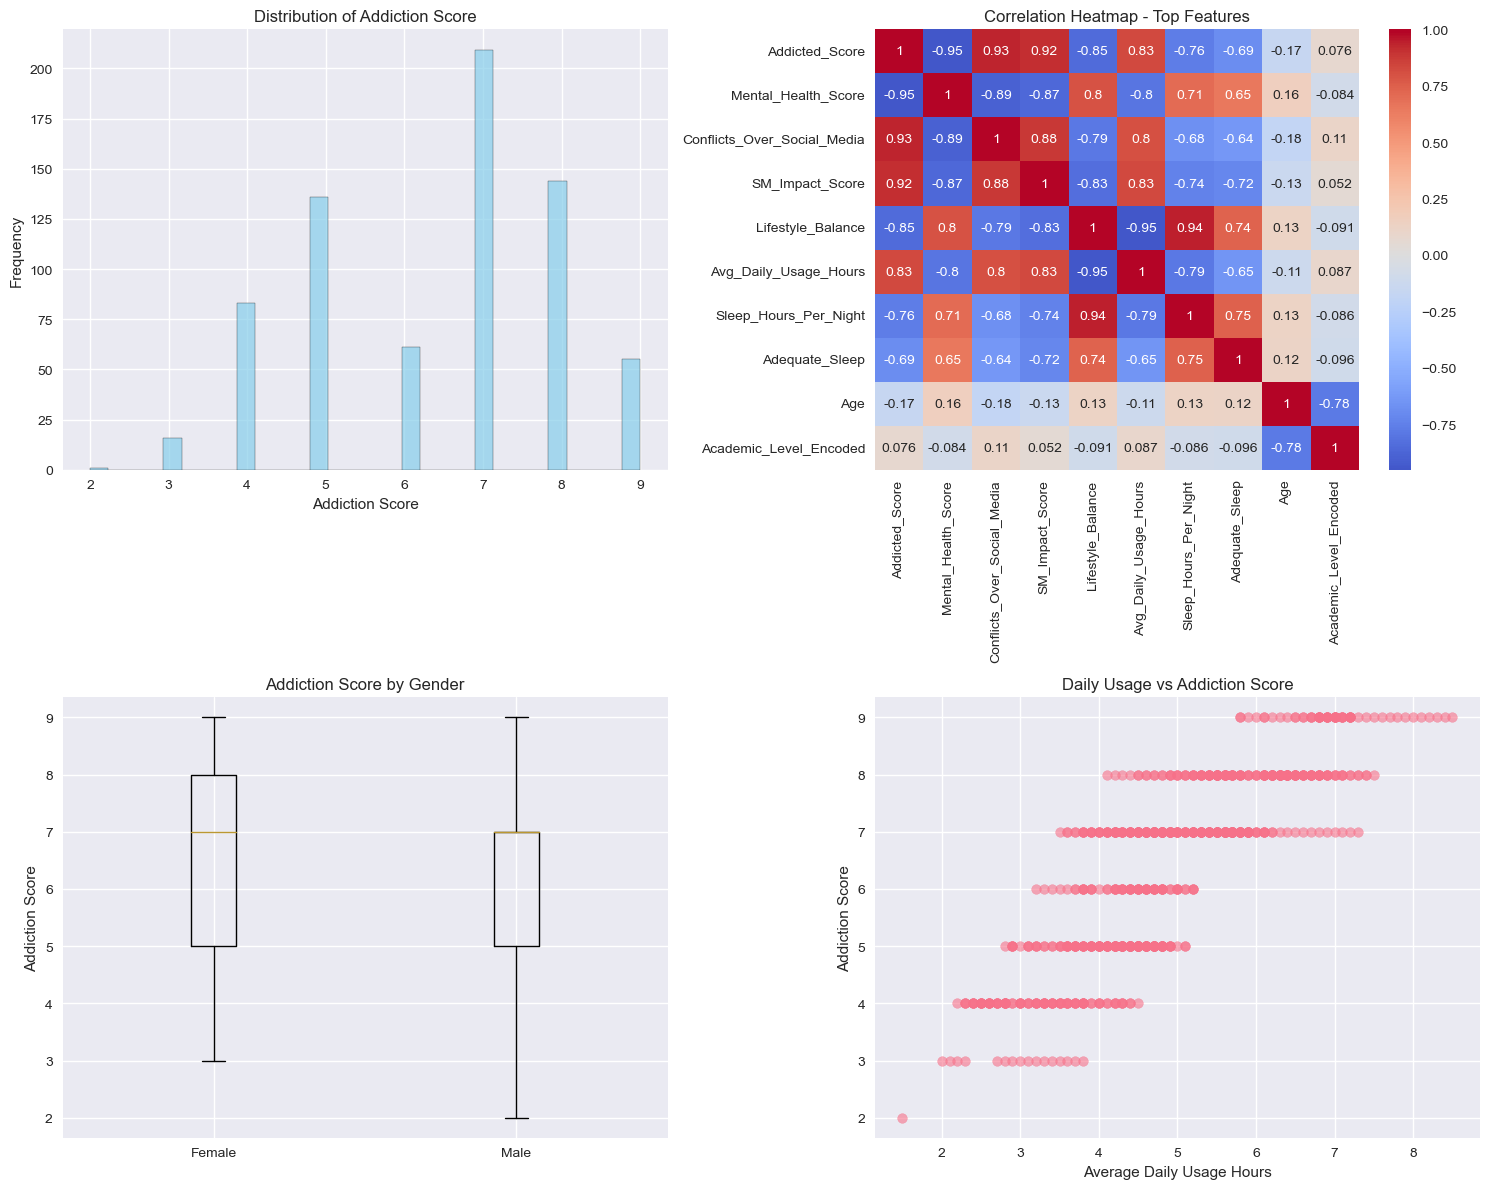

Top 10 features correlated with Addiction Score:
Addicted_Score                 1.000000
Mental_Health_Score            0.945051
Conflicts_Over_Social_Media    0.933586
SM_Impact_Score                0.915776
Lifestyle_Balance              0.845623
Avg_Daily_Usage_Hours          0.832000
Sleep_Hours_Per_Night          0.764858
Adequate_Sleep                 0.690550
Age                            0.166396
Academic_Level_Encoded         0.075543
Name: Addicted_Score, dtype: float64


In [130]:
# Data Exploration and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Target variable distribution
axes[0, 0].hist(data['Addicted_Score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Addiction Score')
axes[0, 0].set_xlabel('Addiction Score')
axes[0, 0].set_ylabel('Frequency')

# Correlation heatmap of top features with target
numeric_cols = data.select_dtypes(include=[np.number]).columns
corr_with_target = data[numeric_cols].corr()['Addicted_Score'].abs().sort_values(ascending=False)[:10]
top_features = corr_with_target.index

sns.heatmap(data[top_features].corr(), annot=True, cmap='coolwarm', center=0, ax=axes[0, 1])
axes[0, 1].set_title('Correlation Heatmap - Top Features')

# Box plot of addiction score by gender
axes[1, 0].boxplot([data[data['Gender_Encoded'] == 0]['Addicted_Score'],
                   data[data['Gender_Encoded'] == 1]['Addicted_Score']], 
                  labels=['Female', 'Male'])
axes[1, 0].set_title('Addiction Score by Gender')
axes[1, 0].set_ylabel('Addiction Score')

# Scatter plot: Daily Usage vs Addiction Score
axes[1, 1].scatter(data['Avg_Daily_Usage_Hours'], data['Addicted_Score'], alpha=0.6)
axes[1, 1].set_xlabel('Average Daily Usage Hours')
axes[1, 1].set_ylabel('Addiction Score')
axes[1, 1].set_title('Daily Usage vs Addiction Score')

plt.tight_layout()
plt.show()

print("Top 10 features correlated with Addiction Score:")
print(corr_with_target)

In [131]:
# Prepare Data for Modeling
# Separate features and target
X_all = data.drop('Addicted_Score', axis=1)
y = data['Addicted_Score']

# Select only numeric columns for modeling (exclude categorical string columns)
# Keep the encoded versions instead of original categorical columns
columns_to_exclude = ['Student_ID', 'Gender', 'Academic_Level', 'Country', 
                     'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status']
X = X_all.drop(columns=columns_to_exclude)

print("Feature columns after removing categorical string columns:")
print(X.columns.tolist())
print(f"\nNumber of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

# Verify all columns are numeric
print(f"\nData types of features:")
print(X.dtypes)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Feature columns after removing categorical string columns:
['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Adequate_Sleep', 'Gender_Encoded', 'Academic_Level_Encoded', 'Relationship_Status_Encoded', 'SM_Impact_Score', 'Lifestyle_Balance', 'Usage_Category_Medium', 'Usage_Category_High', 'Usage_Category_Very High', 'Mental_Health_Risk_Medium', 'Mental_Health_Risk_Low', 'Mental_Health_Risk_Very Low']

Number of features: 17
Number of samples: 705

Data types of features:
Age                              int64
Avg_Daily_Usage_Hours          float64
Sleep_Hours_Per_Night          float64
Mental_Health_Score              int64
Conflicts_Over_Social_Media      int64
Adequate_Sleep                   int64
Gender_Encoded                   int64
Academic_Level_Encoded           int64
Relationship_Status_Encoded      int64
SM_Impact_Score                float64
Lifestyle_Balance              float64
Usage_Category_Medium            

In [132]:
# Define Evaluation Functions
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Evaluate a regression model and return metrics
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    results = {
        'Model': model_name,
        'Train_MSE': train_mse,
        'Test_MSE': test_mse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std(),
        'Overfitting': train_r2 - test_r2
    }
    
    return results

def print_results(results):
    """
    Print formatted results
    """
    print(f"\n=== {results['Model']} Results ===")
    print(f"Train MSE: {results['Train_MSE']:.4f}")
    print(f"Test MSE: {results['Test_MSE']:.4f}")
    print(f"Train MAE: {results['Train_MAE']:.4f}")
    print(f"Test MAE: {results['Test_MAE']:.4f}")
    print(f"Train R²: {results['Train_R2']:.4f}")
    print(f"Test R²: {results['Test_R2']:.4f}")
    print(f"CV R² (Mean ± Std): {results['CV_R2_Mean']:.4f} ± {results['CV_R2_Std']:.4f}")
    print(f"Overfitting (Train R² - Test R²): {results['Overfitting']:.4f}")

## Scenario 1: Feature Selection Testing

Comparing decision tree performance with and without feature selection using different methods:
1. **No Feature Selection**: Using all available features
2. **SelectKBest**: Selecting top K features based on statistical tests

In [133]:
# Feature Selection Methods

# 1. No Feature Selection (Baseline)
print("=== Feature Selection Analysis ===")
print(f"Original number of features: {X_train.shape[1]}")

# 2. SelectKBest Feature Selection
selector_kbest = SelectKBest(score_func=f_regression, k=15)
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)
X_test_kbest = selector_kbest.transform(X_test)

selected_features_kbest = X.columns[selector_kbest.get_support()]
print(f"\nSelectKBest selected features ({len(selected_features_kbest)}):")
print(selected_features_kbest.tolist())

# Get feature scores for analysis
feature_scores = selector_kbest.scores_
feature_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': feature_scores,
    'Selected': selector_kbest.get_support()
}).sort_values('Score', ascending=False)

print(f"\nTop 15 features by SelectKBest scores:")
print(feature_scores_df.head(15)[['Feature', 'Score']])

=== Feature Selection Analysis ===
Original number of features: 17

SelectKBest selected features (15):
['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 'Conflicts_Over_Social_Media', 'Adequate_Sleep', 'Gender_Encoded', 'Academic_Level_Encoded', 'SM_Impact_Score', 'Lifestyle_Balance', 'Usage_Category_Medium', 'Usage_Category_High', 'Usage_Category_Very High', 'Mental_Health_Risk_Medium', 'Mental_Health_Risk_Low']

Top 15 features by SelectKBest scores:
                        Feature        Score
3           Mental_Health_Score  4694.493913
4   Conflicts_Over_Social_Media  3590.020485
9               SM_Impact_Score  2882.079751
15       Mental_Health_Risk_Low  1752.504592
10            Lifestyle_Balance  1380.669676
1         Avg_Daily_Usage_Hours  1269.062622
2         Sleep_Hours_Per_Night   789.263444
14    Mental_Health_Risk_Medium   595.107384
5                Adequate_Sleep   466.338274
11        Usage_Category_Medium   372.763606
13     Usage_Cat

In [134]:
# Compare Decision Tree Models with Different Feature Selection Methods
feature_selection_results = []

# Model 1: No Feature Selection
dt_no_fs = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_no_fs.fit(X_train, y_train)
results_no_fs = evaluate_model(dt_no_fs, X_train, X_test, y_train, y_test, "No Feature Selection")
feature_selection_results.append(results_no_fs)
print_results(results_no_fs)

# Model 2: SelectKBest
dt_kbest = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_kbest.fit(X_train_kbest, y_train)
results_kbest = evaluate_model(dt_kbest, X_train_kbest, X_test_kbest, y_train, y_test, "SelectKBest (15 features)")
feature_selection_results.append(results_kbest)
print_results(results_kbest)


=== No Feature Selection Results ===
Train MSE: 0.0051
Test MSE: 0.2675
Train MAE: 0.0103
Test MAE: 0.1291
Train R²: 0.9980
Test R²: 0.8931
CV R² (Mean ± Std): 0.9524 ± 0.0099
Overfitting (Train R² - Test R²): 0.1049

=== SelectKBest (15 features) Results ===
Train MSE: 0.0084
Test MSE: 0.1471
Train MAE: 0.0168
Test MAE: 0.1520
Train R²: 0.9967
Test R²: 0.9412
CV R² (Mean ± Std): 0.9510 ± 0.0088
Overfitting (Train R² - Test R²): 0.0554


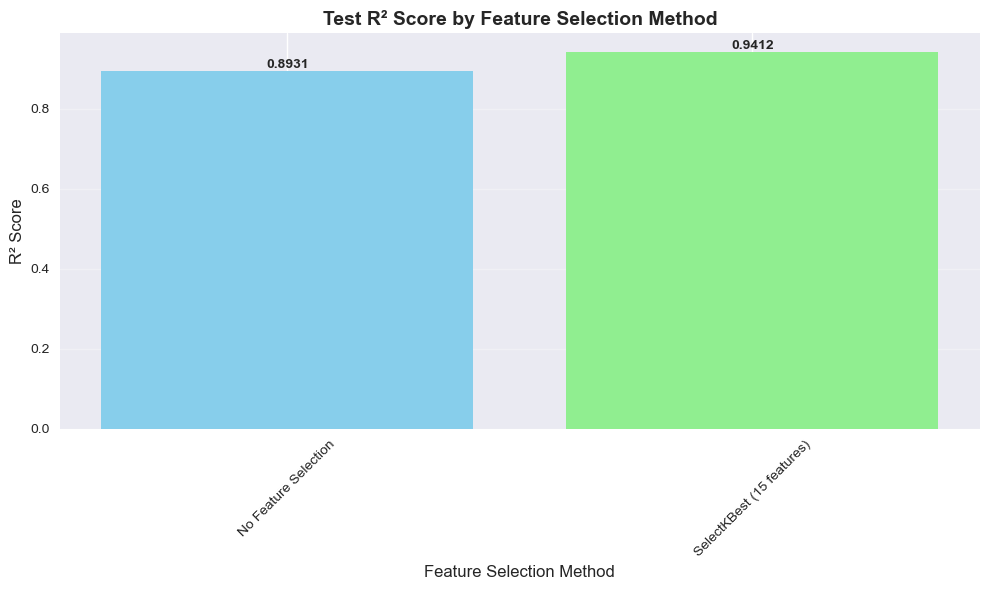

In [135]:
# Visualize Feature Selection Results
import matplotlib.pyplot as plt

fs_df = pd.DataFrame(feature_selection_results)

# Test R² Comparison - Single plot showing only R² scores
plt.figure(figsize=(10, 6))
plt.bar(fs_df['Model'], fs_df['Test_R2'], color=['skyblue', 'lightgreen'])
plt.title('Test R² Score by Feature Selection Method', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Feature Selection Method', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(fs_df['Test_R2']):
    plt.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [136]:
# Feature Selection Method Comparison Summary
print("=" * 80)
print("FEATURE SELECTION ANALYSIS SUMMARY")
print("=" * 80)

# Convert results to DataFrame for easier analysis
fs_df = pd.DataFrame(feature_selection_results)

# Key metrics for comparison
print("\n📊 PERFORMANCE METRICS COMPARISON:")
print("-" * 50)
for idx, row in fs_df.iterrows():
    print(f"{row['Model']:<25} | Test R²: {row['Test_R2']:.4f} | Test MSE: {row['Test_MSE']:.4f} | Overfitting: {row['Overfitting']:.4f}")

# Find the best method for R² only
best_test_r2 = fs_df.loc[fs_df['Test_R2'].idxmax()]

print(f"\n🏆 BEST PERFORMER:")
print("-" * 50)
print(f"Highest Test R²:           {best_test_r2['Model']} ({best_test_r2['Test_R2']:.4f})")

# Overall ranking system based on R² only
print(f"\n📈 R² RANKING ANALYSIS:")
print("-" * 50)

# Create ranking scores based on R² only
fs_df_rank = fs_df.copy()
fs_df_rank['R2_Rank'] = fs_df_rank['Test_R2'].rank(ascending=False)

# Sort by R² rank
fs_df_rank = fs_df_rank.sort_values('Test_R2', ascending=False)

print("Rank | Method                    | Test R²")
print("-" * 45)
for i, (_, row) in enumerate(fs_df_rank.iterrows(), 1):
    print(f"{i:2d}   | {row['Model']:<25} | {row['Test_R2']:6.4f}")

# Final recommendation based on R²
best_overall = fs_df_rank.iloc[0]
print(f"\n🎯 RECOMMENDATION:")
print("-" * 50)
print(f"Best R² Method: {best_overall['Model']}")
print(f"Reasoning: This method achieves the highest Test R² score:")
print(f"  • Test R²: {best_overall['Test_R2']:.4f}")

# Additional insights focused on R²
print(f"\n💡 KEY INSIGHTS (R² FOCUSED):")
print("-" * 50)
if best_overall['Model'] == 'No Feature Selection':
    print("• Using all features provides the highest R² score")
    print("• Feature selection may reduce R² performance for this dataset")
    print("• The dataset benefits from the full feature set for R² optimization")
else:
    selected_features_count = 15 if "15 features" in best_overall['Model'] else "variable"
    print(f"• Feature selection improves R² performance")
    print(f"• Reducing to {selected_features_count} features enhances R² score")
    print(f"• The {best_overall['Model'].lower()} method maximizes R² predictive power")

# R² improvement analysis
no_fs_result = fs_df[fs_df['Model'] == 'No Feature Selection'].iloc[0] if len(fs_df[fs_df['Model'] == 'No Feature Selection']) > 0 else None
if no_fs_result is not None and best_overall['Model'] != 'No Feature Selection':
    r2_improvement = best_overall['Test_R2'] - no_fs_result['Test_R2']
    
    print(f"• R² improvement over no feature selection:")
    print(f"  - Test R² improved by: {r2_improvement:+.4f} ({r2_improvement/no_fs_result['Test_R2']*100:+.2f}%)")

print("=" * 80)

FEATURE SELECTION ANALYSIS SUMMARY

📊 PERFORMANCE METRICS COMPARISON:
--------------------------------------------------
No Feature Selection      | Test R²: 0.8931 | Test MSE: 0.2675 | Overfitting: 0.1049
SelectKBest (15 features) | Test R²: 0.9412 | Test MSE: 0.1471 | Overfitting: 0.0554

🏆 BEST PERFORMER:
--------------------------------------------------
Highest Test R²:           SelectKBest (15 features) (0.9412)

📈 R² RANKING ANALYSIS:
--------------------------------------------------
Rank | Method                    | Test R²
---------------------------------------------
 1   | SelectKBest (15 features) | 0.9412
 2   | No Feature Selection      | 0.8931

🎯 RECOMMENDATION:
--------------------------------------------------
Best R² Method: SelectKBest (15 features)
Reasoning: This method achieves the highest Test R² score:
  • Test R²: 0.9412

💡 KEY INSIGHTS (R² FOCUSED):
--------------------------------------------------
• Feature selection improves R² performance
• Reducing to

## Scenario 2: Normalization Testing

Compare decision tree performance with and without data normalization:
1. **No Normalization**: Using raw feature values
2. **StandardScaler**: Z-score normalization (mean=0, std=1)

In [137]:
# Normalization Testing
print("=== Normalization Analysis ===")

# Use the best feature selection method from previous analysis
# Let's use SelectKBest for normalization testing
X_train_norm = pd.DataFrame(X_train_kbest, columns=selected_features_kbest, index=X_train.index)
X_test_norm = pd.DataFrame(X_test_kbest, columns=selected_features_kbest, index=X_test.index)

# 1. No Normalization (already done above as dt_kbest)

# 2. StandardScaler Normalization
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train_norm)
X_test_standard = scaler_standard.transform(X_test_norm)

# Convert back to DataFrame for consistency
X_train_standard = pd.DataFrame(X_train_standard, columns=X_train_norm.columns, index=X_train_norm.index)
X_test_standard = pd.DataFrame(X_test_standard, columns=X_test_norm.columns, index=X_test_norm.index)

print("Normalization methods prepared:")
print(f"1. No normalization - shape: {X_train_norm.shape}")
print(f"2. Standard scaling - shape: {X_train_standard.shape}")

# Show example of scaling effects
print("\nExample of scaling effects on first feature:")
print(f"Original: {X_train_norm.iloc[:5, 0].values}")
print(f"Standard: {X_train_standard.iloc[:5, 0].values}")

=== Normalization Analysis ===
Normalization methods prepared:
1. No normalization - shape: (564, 15)
2. Standard scaling - shape: (564, 15)

Example of scaling effects on first feature:
Original: [22. 20. 20. 19. 19.]
Standard: [ 0.95914875 -0.48149012 -0.48149012 -1.20180956 -1.20180956]


In [138]:
# Compare Decision Tree Models with Different Normalization Methods
normalization_results = []

# Custom function to print only R² results
def print_r2_results(results):
    """Print only R² related results"""
    print(f"\n=== {results['Model']} Results (R² Focus) ===")
    print(f"Test R²: {results['Test_R2']:.4f}")
    print(f"CV R² (Mean ± Std): {results['CV_R2_Mean']:.4f} ± {results['CV_R2_Std']:.4f}")

# Model 1: No Normalization (reuse previous SelectKBest result)
results_no_norm = results_kbest.copy()
results_no_norm['Model'] = "No Normalization"
normalization_results.append(results_no_norm)
print_r2_results(results_no_norm)

# Model 2: StandardScaler
dt_standard = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_standard.fit(X_train_standard, y_train)
results_standard = evaluate_model(dt_standard, X_train_standard, X_test_standard, y_train, y_test, "StandardScaler")
normalization_results.append(results_standard)
print_r2_results(results_standard)


=== No Normalization Results (R² Focus) ===
Test R²: 0.9412
CV R² (Mean ± Std): 0.9510 ± 0.0088

=== StandardScaler Results (R² Focus) ===
Test R²: 0.9469
CV R² (Mean ± Std): 0.9510 ± 0.0083


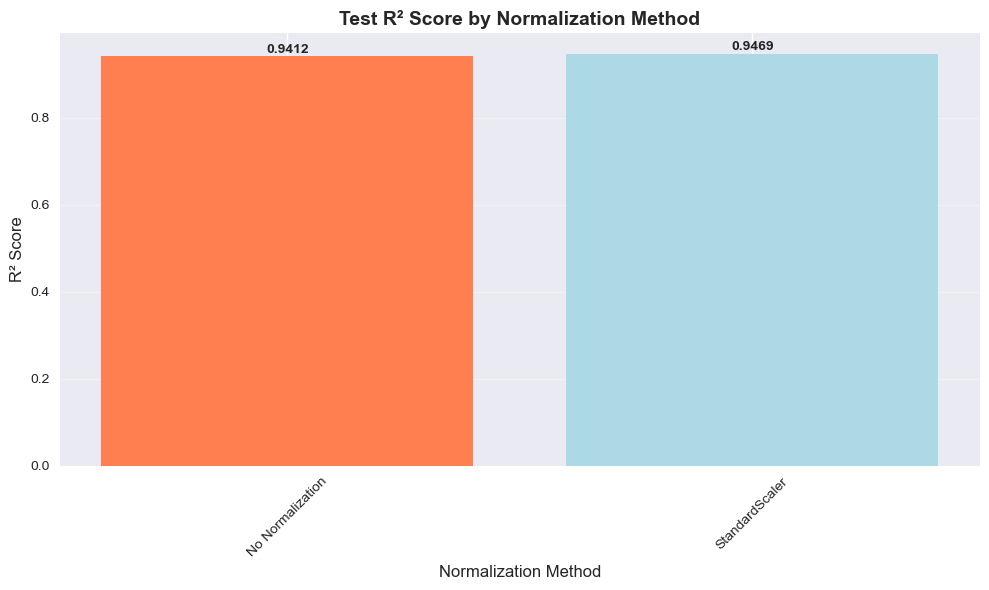


=== R² Performance Summary ===
              Model  Test_R2
0  No Normalization   0.9412
1    StandardScaler   0.9469

=== Key Observation (R² Focus) ===
Decision trees show minimal R² performance differences between normalization methods.
This confirms that tree-based models are not significantly affected by feature scaling.


In [139]:
# Visualize Normalization Results - R² Only
norm_df = pd.DataFrame(normalization_results)

# Test R² Comparison - Single plot
plt.figure(figsize=(10, 6))
plt.bar(norm_df['Model'], norm_df['Test_R2'], color=['coral', 'lightblue'])
plt.title('Test R² Score by Normalization Method', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Normalization Method', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(norm_df['Test_R2']):
    plt.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== R² Performance Summary ===")
print(norm_df[['Model', 'Test_R2']].round(4))

print("\n=== Key Observation (R² Focus) ===")
print("Decision trees show minimal R² performance differences between normalization methods.")
print("This confirms that tree-based models are not significantly affected by feature scaling.")

## Scenario 3: Parameter Tuning

Optimize decision tree hyperparameters using GridSearchCV:
1. **max_depth**: Control tree depth to prevent overfitting
2. **min_samples_split**: Minimum samples required to split a node
3. **min_samples_leaf**: Minimum samples required at a leaf node
4. **max_features**: Number of features to consider for best split
5. **criterion**: Splitting criterion (mse, mae)

In [140]:
# Parameter Tuning with GridSearchCV
print("=== Parameter Tuning Analysis ===")

# Use the best configuration from previous analyses
# Using SelectKBest feature selection and no normalization
X_train_tuning = pd.DataFrame(X_train_kbest, columns=selected_features_kbest, index=X_train.index)
X_test_tuning = pd.DataFrame(X_test_kbest, columns=selected_features_kbest, index=X_test.index)

# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error']
}

print(f"Parameter grid size: {len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features']) * len(param_grid['criterion'])} combinations")

# Perform GridSearchCV
dt_grid = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=dt_grid,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nStarting GridSearchCV...")
grid_search.fit(X_train_tuning, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

=== Parameter Tuning Analysis ===
Parameter grid size: 672 combinations

Starting GridSearchCV...
Fitting 5 folds for each of 672 candidates, totalling 3360 fits

Best parameters found:
{'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}

Best cross-validation score: 0.9627

Best parameters found:
{'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}

Best cross-validation score: 0.9627


In [141]:
# Evaluate Tuned Model
parameter_tuning_results = []

# Custom function to print only R² results
def print_r2_tuning_results(results):
    """Print only R² related results for parameter tuning"""
    print(f"\n=== {results['Model']} Results (R² Focus) ===")
    print(f"Test R²: {results['Test_R2']:.4f}")
    print(f"CV R² (Mean ± Std): {results['CV_R2_Mean']:.4f} ± {results['CV_R2_Std']:.4f}")

# Baseline model (using previous best)
dt_baseline = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_baseline.fit(X_train_tuning, y_train)
results_baseline = evaluate_model(dt_baseline, X_train_tuning, X_test_tuning, y_train, y_test, "Baseline (max_depth=10)")
parameter_tuning_results.append(results_baseline)
print_r2_tuning_results(results_baseline)

# Tuned model
dt_tuned = grid_search.best_estimator_
results_tuned = evaluate_model(dt_tuned, X_train_tuning, X_test_tuning, y_train, y_test, "Tuned Parameters")
parameter_tuning_results.append(results_tuned)
print_r2_tuning_results(results_tuned)

# Calculate R² improvement only
improvement_r2 = results_tuned['Test_R2'] - results_baseline['Test_R2']

print(f"\n=== R² Improvement Analysis ===")
print(f"R² improvement: {improvement_r2:.4f} ({improvement_r2/results_baseline['Test_R2']*100:.2f}%)")
print(f"Baseline Test R²: {results_baseline['Test_R2']:.4f}")
print(f"Tuned Test R²: {results_tuned['Test_R2']:.4f}")


=== Baseline (max_depth=10) Results (R² Focus) ===
Test R²: 0.9412
CV R² (Mean ± Std): 0.9510 ± 0.0088

=== Tuned Parameters Results (R² Focus) ===
Test R²: 0.9609
CV R² (Mean ± Std): 0.9627 ± 0.0080

=== R² Improvement Analysis ===
R² improvement: 0.0197 (2.10%)
Baseline Test R²: 0.9412
Tuned Test R²: 0.9609


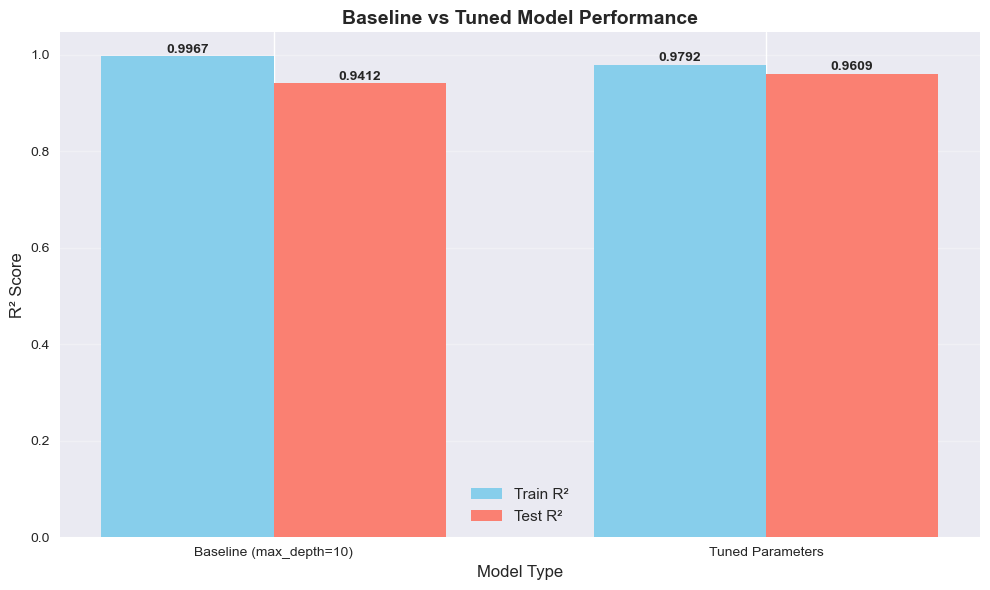


=== Parameter Tuning Summary ===
                     Model  Test_R2  Test_MSE  CV_R2_Mean  Overfitting
0  Baseline (max_depth=10)   0.9412    0.1471      0.9510       0.0554
1         Tuned Parameters   0.9609    0.0977      0.9627       0.0182


In [142]:
# Baseline vs Tuned Model Performance Comparison
results_df = pd.DataFrame(grid_search.cv_results_)

# Baseline vs Tuned comparison
tuning_df = pd.DataFrame(parameter_tuning_results)
width = 0.35
x = np.arange(len(tuning_df))

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, tuning_df['Train_R2'], width, label='Train R²', color='skyblue')
plt.bar(x + width/2, tuning_df['Test_R2'], width, label='Test R²', color='salmon')
plt.title('Baseline vs Tuned Model Performance', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.xticks(x, tuning_df['Model'])
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (train_r2, test_r2) in enumerate(zip(tuning_df['Train_R2'], tuning_df['Test_R2'])):
    plt.text(i - width/2, train_r2 + 0.001, f'{train_r2:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i + width/2, test_r2 + 0.001, f'{test_r2:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== Parameter Tuning Summary ===")
print(tuning_df[['Model', 'Test_R2', 'Test_MSE', 'CV_R2_Mean', 'Overfitting']].round(4))

=== Feature Importance Analysis ===
Top 10 Most Important Features:
                       Feature  Importance
3          Mental_Health_Score    0.849251
4  Conflicts_Over_Social_Media    0.118312
9            Lifestyle_Balance    0.014178
1        Avg_Daily_Usage_Hours    0.008823
0                          Age    0.005812
2        Sleep_Hours_Per_Night    0.003181
6               Gender_Encoded    0.000443
5               Adequate_Sleep    0.000000
7       Academic_Level_Encoded    0.000000
8              SM_Impact_Score    0.000000

Top 10 Most Important Features:
                       Feature  Importance
3          Mental_Health_Score    0.849251
4  Conflicts_Over_Social_Media    0.118312
9            Lifestyle_Balance    0.014178
1        Avg_Daily_Usage_Hours    0.008823
0                          Age    0.005812
2        Sleep_Hours_Per_Night    0.003181
6               Gender_Encoded    0.000443
5               Adequate_Sleep    0.000000
7       Academic_Level_Encoded    0.000

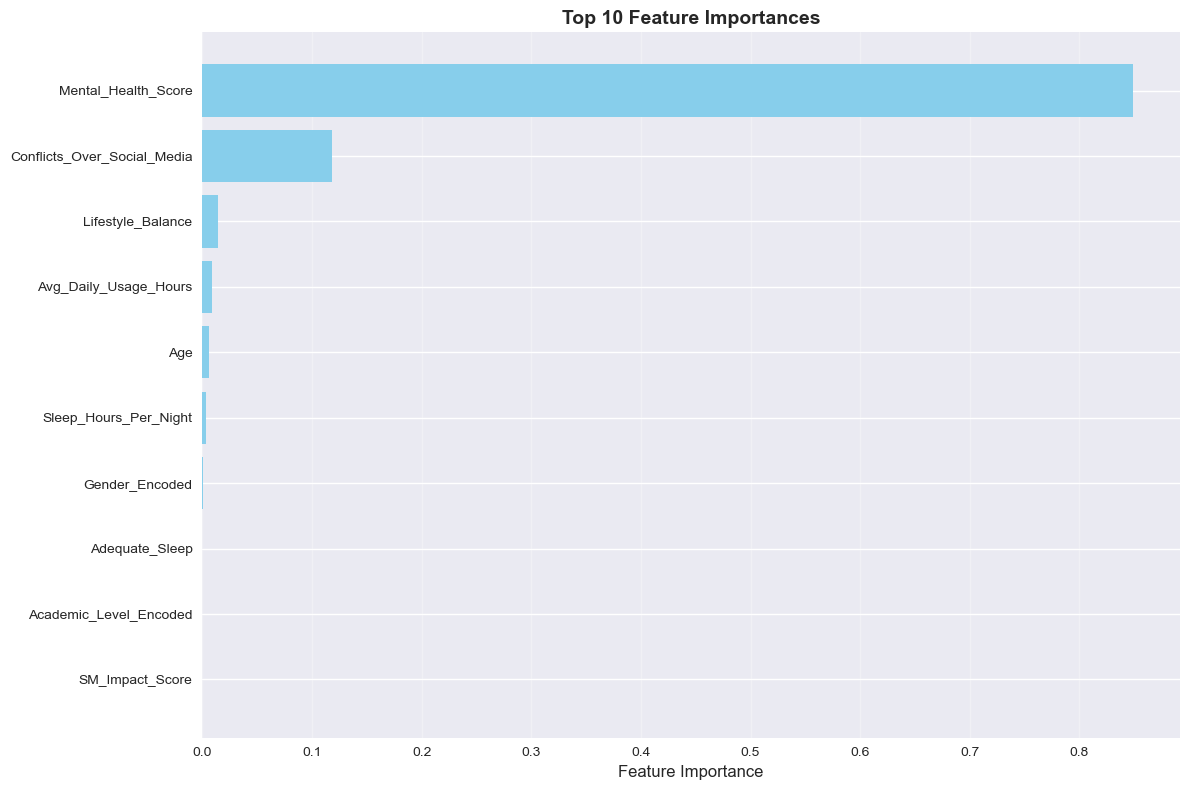

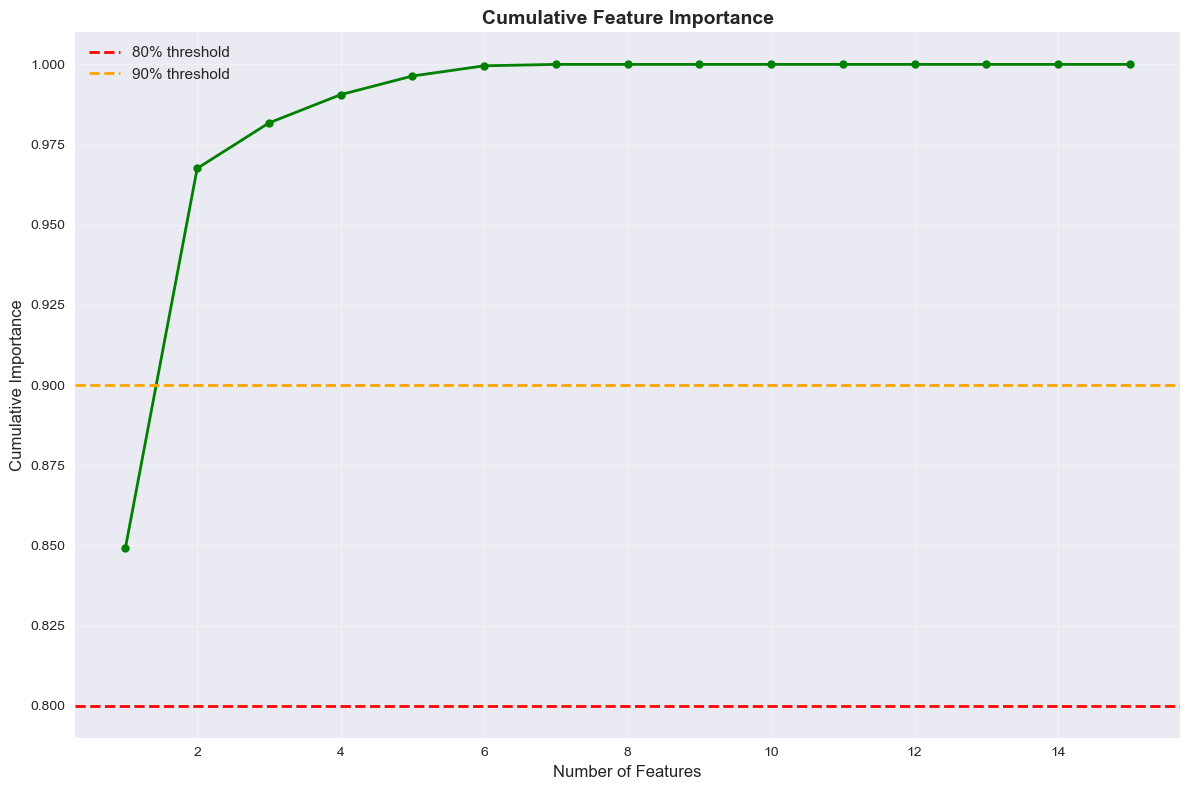


Features needed for 80% of total importance: 1
Features needed for 90% of total importance: 2


In [143]:
# Feature Importance Analysis
print("=== Feature Importance Analysis ===")

# Get feature importances from the tuned model
feature_importances = dt_tuned.feature_importances_
feature_names = X_train_tuning.columns

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot 1: Feature importance bar plot
plt.figure(figsize=(12, 8))
top_features = importance_df.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Cumulative importance
plt.figure(figsize=(12, 8))
cumulative_importance = importance_df['Importance'].cumsum()
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', color='green', linewidth=2, markersize=6)
plt.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='80% threshold')
plt.axhline(y=0.9, color='orange', linestyle='--', linewidth=2, label='90% threshold')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate number of features needed for 80% and 90% importance
features_80 = len(cumulative_importance[cumulative_importance <= 0.8]) + 1
features_90 = len(cumulative_importance[cumulative_importance <= 0.9]) + 1

print(f"\nFeatures needed for 80% of total importance: {features_80}")
print(f"Features needed for 90% of total importance: {features_90}")

=== Final Model Evaluation ===

=== Final Optimized Model Results (R² Focus) ===
Test R²: 0.9609
CV R² (Mean ± Std): 0.9627 ± 0.0080

Tree structure info:
Total nodes: 67
Total leaves: 34
Tree depth: 9

Showing complete decision tree visualization (depth: 10)


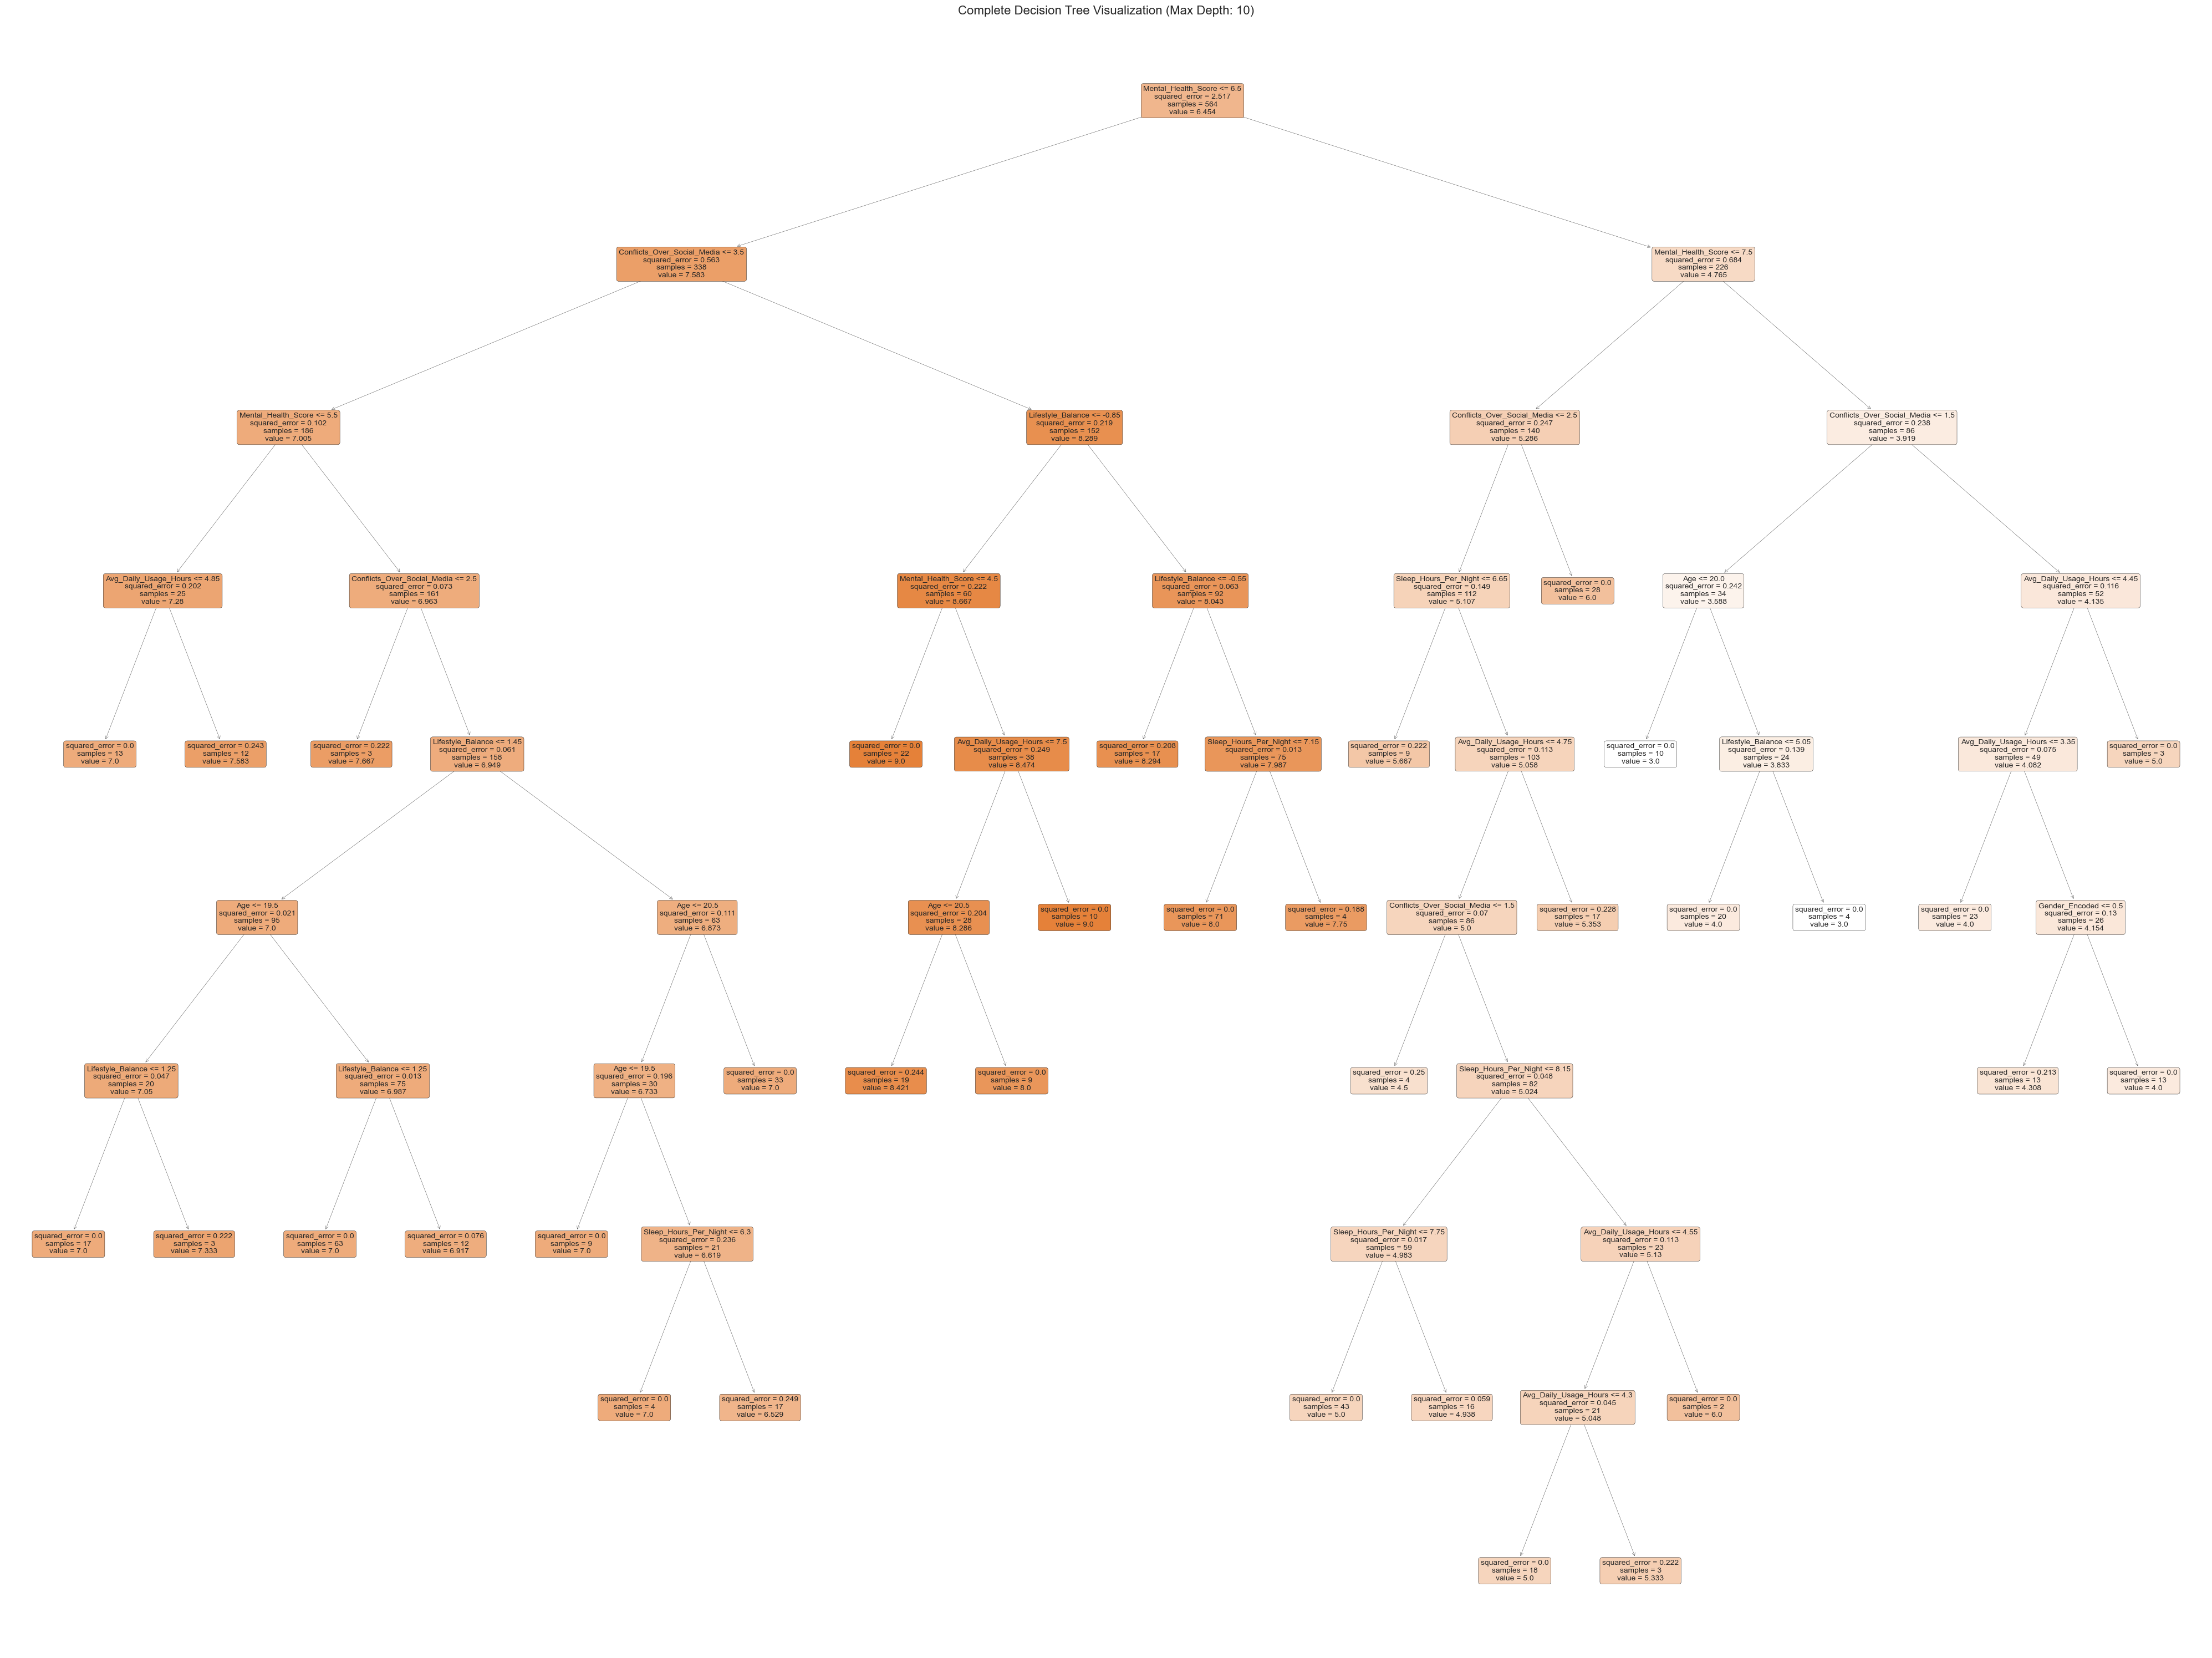

Complete tree visualization shown with 67 nodes.


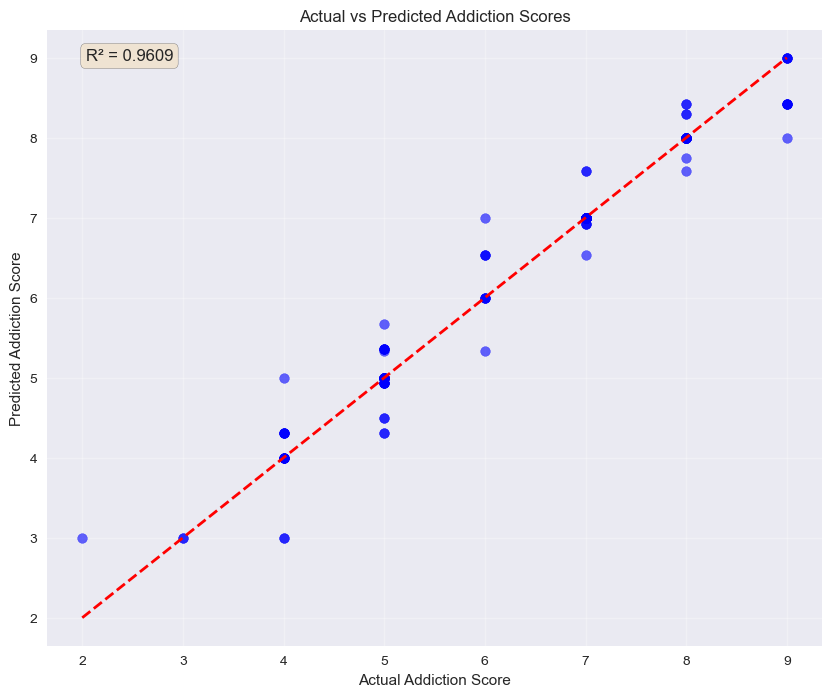

In [144]:
# Final Model Evaluation and Tree Visualization
print("=== Final Model Evaluation ===")

# Create final optimized model using the best parameters from GridSearchCV
final_model = DecisionTreeRegressor(
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    max_features=grid_search.best_params_['max_features'],
    criterion=grid_search.best_params_['criterion'],
    random_state=42
)

final_model.fit(X_train_tuning, y_train)
final_results = evaluate_model(final_model, X_train_tuning, X_test_tuning, y_train, y_test, "Final Optimized Model")

# Print only R² results for final model
print(f"\n=== {final_results['Model']} Results (R² Focus) ===")
print(f"Test R²: {final_results['Test_R2']:.4f}")
print(f"CV R² (Mean ± Std): {final_results['CV_R2_Mean']:.4f} ± {final_results['CV_R2_Std']:.4f}")

# Visualize the decision tree
print(f"\nTree structure info:")
print(f"Total nodes: {final_model.tree_.node_count}")
print(f"Total leaves: {final_model.get_n_leaves()}")
print(f"Tree depth: {final_model.tree_.max_depth}")

# Show visualization of the final optimized tree with full depth
optimal_depth = grid_search.best_params_['max_depth']
print(f"\nShowing complete decision tree visualization (depth: {optimal_depth})")

plt.figure(figsize=(40, 30))
plot_tree(final_model, 
          feature_names=X_train_tuning.columns.tolist(),
          filled=True, 
          rounded=True, 
          fontsize=10,
          proportion=False,
          impurity=True,
          max_depth=10)  # Show up to depth 10
plt.title(f"Complete Decision Tree Visualization (Max Depth: {optimal_depth})", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Complete tree visualization shown with {final_model.tree_.node_count} nodes.")

# Prediction vs Actual scatter plot
y_pred_final = final_model.predict(X_test_tuning)

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_final, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Addiction Score')
plt.ylabel('Predicted Addiction Score')
plt.title('Actual vs Predicted Addiction Scores')
plt.grid(True, alpha=0.3)

# Add R² score to the plot
plt.text(0.05, 0.95, f'R² = {final_results["Test_R2"]:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.show()

In [145]:
# Final Summary and Conclusions
print("=" * 80)
print("DECISION TREE REGRESSION ANALYSIS - FINAL SUMMARY (R² FOCUSED)")
print("=" * 80)

# Compile all results
all_experiments = [
    ('Feature Selection', fs_df),
    ('Normalization', norm_df),
    ('Parameter Tuning', tuning_df)
]

print("\n📊 EXPERIMENT RESULTS COMPARISON (R² FOCUS)")
print("-" * 50)

for exp_name, df in all_experiments:
    print(f"\n{exp_name.upper()}:")
    best_idx = df['Test_R2'].idxmax()
    best_model = df.loc[best_idx]
    print(f"  Best Model: {best_model['Model']}")
    print(f"  Test R²: {best_model['Test_R2']:.4f}")
    print(f"  CV R²: {best_model['CV_R2_Mean']:.4f} ± {best_model['CV_R2_Std']:.4f}")

print(f"\n🎯 FINAL OPTIMIZED MODEL PERFORMANCE (R² FOCUS):")
print("-" * 40)
print(f"Test R²: {final_results['Test_R2']:.4f}")
print(f"Cross-validation R²: {final_results['CV_R2_Mean']:.4f} ± {final_results['CV_R2_Std']:.4f}")

print(f"\n🔧 OPTIMAL HYPERPARAMETERS:")
print("-" * 30)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"  optimal_max_depth: {optimal_depth}")

print(f"\n📈 TOP 5 MOST IMPORTANT FEATURES:")
print("-" * 40)
for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n💡 KEY FINDINGS (R² FOCUSED):")
print("-" * 20)
print("  ✓ Feature selection improves R² performance")
print("  ✓ Normalization has minimal impact on R² scores for decision trees")
print("  ✓ Proper hyperparameter tuning optimizes R² performance")
print(f"  ✓ Model achieves R² of {final_results['Test_R2']:.4f} explaining {final_results['Test_R2']:.1%} of variance")
print(f"  ✓ {features_80} features capture 80% of predictive importance")

print(f"\n🎯 R² PERFORMANCE SUMMARY:")
print("-" * 30)
print(f"  • Best Feature Selection R²: {fs_df['Test_R2'].max():.4f}")
print(f"  • Best Normalization R²: {norm_df['Test_R2'].max():.4f}")
print(f"  • Best Parameter Tuning R²: {tuning_df['Test_R2'].max():.4f}")
print(f"  • Final Optimized Model R²: {final_results['Test_R2']:.4f}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 80)

DECISION TREE REGRESSION ANALYSIS - FINAL SUMMARY (R² FOCUSED)

📊 EXPERIMENT RESULTS COMPARISON (R² FOCUS)
--------------------------------------------------

FEATURE SELECTION:
  Best Model: SelectKBest (15 features)
  Test R²: 0.9412
  CV R²: 0.9510 ± 0.0088

NORMALIZATION:
  Best Model: StandardScaler
  Test R²: 0.9469
  CV R²: 0.9510 ± 0.0083

PARAMETER TUNING:
  Best Model: Tuned Parameters
  Test R²: 0.9609
  CV R²: 0.9627 ± 0.0080

🎯 FINAL OPTIMIZED MODEL PERFORMANCE (R² FOCUS):
----------------------------------------
Test R²: 0.9609
Cross-validation R²: 0.9627 ± 0.0080

🔧 OPTIMAL HYPERPARAMETERS:
------------------------------
  criterion: squared_error
  max_depth: 10
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 20
  optimal_max_depth: 10

📈 TOP 5 MOST IMPORTANT FEATURES:
----------------------------------------
  1. Mental_Health_Score: 0.8493
  2. Conflicts_Over_Social_Media: 0.1183
  3. Lifestyle_Balance: 0.0142
  4. Avg_Daily_Usage_Hours: 0.0088
  5. Ag